# 📊 PII Detection Systems Comparison
This notebook compares the evaluation results of two PII detection systems:

1. **LLM-based system**
2. **HF/SpaCy/Presidio system**

The comparison focuses on the overlap of detected entities and calculates Precision, Recall, and F1-Score.

In [1]:

import json
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support


In [2]:

# Load the JSON files
with open("C:/Users/ousse/Desktop/pii/augmented_data_partial_with_pii_detection.json", "r", encoding="utf-8") as f:
    llm_data = json.load(f)

with open("C:/Users/ousse/Desktop/pii_detection_results.json", "r", encoding="utf-8") as f:
    hf_data = json.load(f)


In [3]:

def extract_llm_entities(entry):
    try:
        return json.loads(entry["entities"])
    except json.JSONDecodeError:
        return []

def extract_hf_entities(entry):
    return entry.get("detected_entities", [])

def normalize_entities(entities, system):
    normalized = []
    for entity in entities:
        normalized.append({
            "text": entity["text"].lower(),
            "type": entity["type"],
            "system": system
        })
    return normalized

llm_entities = []
hf_entities = []

for llm_entry, hf_entry in zip(llm_data, hf_data):
    llm_entities.extend(normalize_entities(extract_llm_entities(llm_entry), "LLM"))
    hf_entities.extend(normalize_entities(extract_hf_entities(hf_entry), "HF"))


In [5]:

llm_texts = set((e["text"], e["type"]) for e in llm_entities)
hf_texts = set((e["text"], e["type"]) for e in hf_entities)

true_positives = llm_texts & hf_texts
false_positives = llm_texts - hf_texts
false_negatives = hf_texts - llm_texts

precision = len(true_positives) / (len(true_positives) + len(false_positives)) if (len(true_positives) + len(false_positives)) else 0
recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if (len(true_positives) + len(false_negatives)) else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

results = {
    "Total LLM Entities": len(llm_texts),
    "Total HF Entities": len(hf_texts),
    "True Positives": len(true_positives),
    "False Positives (LLM only)": len(false_positives),
    "False Negatives (HF only)": len(false_negatives),
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
}

results_df = pd.DataFrame([results])
results_df


,Total LLM Entities,Total HF Entities,True Positives,False Positives (LLM only),False Negatives (HF only),Precision,Recall,F1 Score
0,2281,1013,26,2255,987,0.011399,0.025666,0.015786


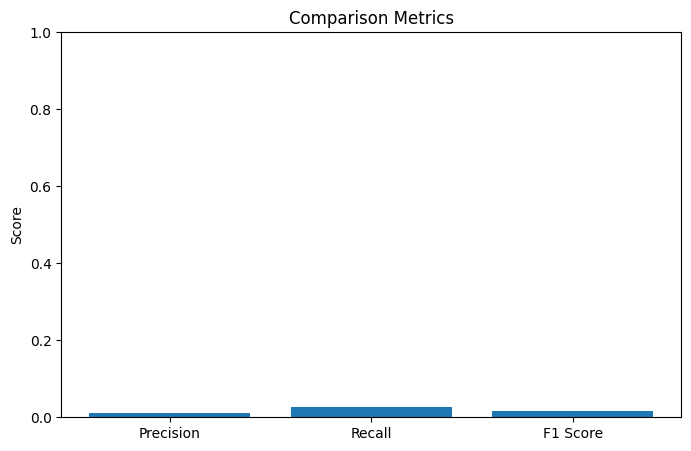

In [6]:

import matplotlib.pyplot as plt

metrics = ["Precision", "Recall", "F1 Score"]
values = [precision, recall, f1_score]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values)
plt.title("Comparison Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()
